In [184]:
import random
import numpy as np

import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt

In [4]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ".")

The agents ($i$'s):

Problem_solving = $S_i$ # from 0 to 1$

Cps_level = $L_i$ 
    - if problem solving is 1.92 to 2 then cps level is 4 
    - if problem solving is 1.64 to 1.92 then cps level is 3
    - if problem solving is 1.29 to 1.64 then cps level is 2
    - if problem solving is 1 to 1.29 then cps level is 1 

Communication = $C_i$# from 1 to 2 (!for now)

Grid / The Tasks:
- Task_Complexity = From 0 to 1

The AgentStep:
At each tick the agent evaluates the current problem solving ability of all agents on the grid and either 1. moves, 2. communicates or work
1. Move
- If *i* !working then move_to() nearby grid

2. Evaluate
- If $S_i$ > Task_Complexity then work individually
- If $S_i$ <= Task_Complexity then suggest Collaboration

3. Communicate / Collaborate
- Communicate with a nearby agent in the "8" squares around (!For now - look in communication litetarture)
    - Communication : Succes = 50% (!For now - comm literature) * $C_i$
    - If Communication == Success then intiate collaboration discussion
    31. Collab Discussion
    - Agent $i$ sends to $i_R$(Receiver)
    - if $i_R$ !working then $i_R$ jumps to task (!for now - maybe add a propability, such that a person with low $S_i$ might not join task, to reflect natural errors)
    - if $i_R$ :working then:
        - $i$ joins grid_cell if $S_i$ + $S_{i_R}$ > Task_Complexity

4. Work
- If problem solving ability of all agents is larger than Task complexity then begin working
- One tick is used on working instead of moving or communicating








In [167]:
class TeamAgent(mesa.Agent):
    """An agent in a team with a range of teamwork skill parameters"""

    def __init__(self, unique_id, model, problem_solving, communication, cps_level):
        super().__init__(unique_id, model)
        self.problem_solving = problem_solving # 1 to 2 # how good they are at solving problems
        self.cps_level = cps_level # 1 to 4 # how good they are at solving problems
        self.communication =  communication # 0.5 to 1.5 # how good they are at communicating
        self.working = False # By default the will not work on a task
        self.accomplished = 0 # by default they have not accomplished any tasks
        self.task_complexity = 0 # By default the agent has no task dealt
        self.pos

        self.collaboration_succes = False
    
    # a function which draws a task after each move
    def draw_a_task(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) == 1:
            self.task_complexity = random.uniform(0, 2) # adding task complexity
 

    
    # A move function which will be used for the step function later on
    def move(self):
            possible_moves = self.model.grid.get_neighborhood(  # retrieve neighborhood grids
                self.pos, moore=True, include_center=False 
            )
            new_position = random.choice(possible_moves) #
            self.model.grid.move_agent(self, new_position)
            self.working = False

    def grid_problem_solving(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos]) # Retrieves a a list of all agents in the same cell
        team_problem_solving = 0
        if len(cellmates) > 1:
            for mate in cellmates:
                team_problem_solving += mate.problem_solving
        return team_problem_solving
    

    def evaluate(self):
    
        cellmates = self.model.grid.get_cell_list_contents([self.pos]) # Retrieves a a list of all agents in the same cell
        self.team_problem_solving = self.grid_problem_solving() # get the problem solving of the team
    

        if self.team_problem_solving >= self.task_complexity:
            if len(cellmates) == 1:
                self.work_individually()
            else: 
                self.collaborating = True
                self.work_as_a_team()
        elif self.team_problem_solving < self.task_complexity:
            self.suggest_collaboration()
            if not self.collaboration_succes:
                self.move
            elif self.collaboration_succes:
                self.work_as_a_team()
    
    def work_individually(self):

            self.accomplished += 1
            self.model.total_accomplished += 1
            self.move()
    
    def work_as_a_team(self):
            self.working = True
            self.accomplished += 1
            self.model.total_accomplished += 1
            self.move()

    def suggest_collaboration(self):
        
        neighbors = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False
        )
        for neighbor in neighbors:
            if not neighbor.working and ( neighbor.problem_solving + self.problem_solving ) > self.task_complexity:
                neighbor.model.grid.move_agent(neighbor, self.pos)
                self.task_complexity = neighbor.task_complexity
                self.collaboration_succes = True
            else:
                self.collaboration_succes = False
    
        
            

        
    
  #      for neighbor in self.model.grid.neighbor_iter(self.pos):
  #          if neighbor.problem_solving + self.problem_solving > task_complexity:
  #              similar += 1

    def step(self):
        self.draw_a_task()
        self.evaluate()
        


In [174]:

# Create the model
class TeamworkModel(mesa.Model):
    """ A model with some number of agents."""
    
    def __init__(self, num_agents, width, height):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus=True)
        self.schedule = RandomActivation(self)

        def get_cps_level(problem_solving_value):
            if problem_solving_value >= 1.92 and problem_solving_value <= 2:
                return 4
            elif problem_solving_value >= 1.64 and problem_solving_value < 1.92:
                return 3
            elif problem_solving_value >= 1.29 and problem_solving_value < 1.64:
                return 2
            elif problem_solving_value >= 1 and problem_solving_value < 1.29:
                return 1
            else:
                return None

        # Create agents
        for i in range(self.num_agents):
            problem_solving = random.random() 
            communication = random.random() + 0.5
            cps_level = get_cps_level(problem_solving)
            agent = TeamAgent(i, self, problem_solving, communication, cps_level)
            self.schedule.add(agent)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        self.total_accomplished = 0

        self.datacollector = mesa.DataCollector(
            {"Accomplished": "total_accomplished"}
        )


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [219]:
# Create the model and run the simulation
model = TeamworkModel(num_agents=10, width=10, height=10)

for i in range(200):
    model.step()


# quick print some different parameters for the first schedueled run (i think or the last maybe)
for agent in model.schedule.agents:
    print(agent.pos)
    print(agent.task_complexity)
    print(agent.problem_solving)
    print(agent.accomplished)

(2, 8)
1.134260983798932
0.33926398087333265
14
(4, 2)
1.992261609407225
0.6842654116919684
34
(9, 5)
0.22250658366471954
0.8808213870646254
0
(1, 9)
1.5677414296470844
0.7778922972961436
48
(7, 5)
1.496855267080075
0.05693902340893742
32
(5, 1)
1.992261609407225
0.3058898053325194
17
(2, 6)
0.4112500938891148
0.22169667263668347
8
(1, 9)
1.5677414296470844
0.714358460228195
37
(2, 8)
1.134260983798932
0.1505060459553773
2
(7, 6)
1.3847147807131828
0.4926980905326278
18


In [217]:
# creating a batch run which runs the model multiple times
params = {"width": 10, "height": 10, "num_agents": 10}

results = mesa.batch_run(
    TeamworkModel,
    parameters=params,
    iterations=10,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'TeamworkModel' object has no attribute 'running'

<Axes: >

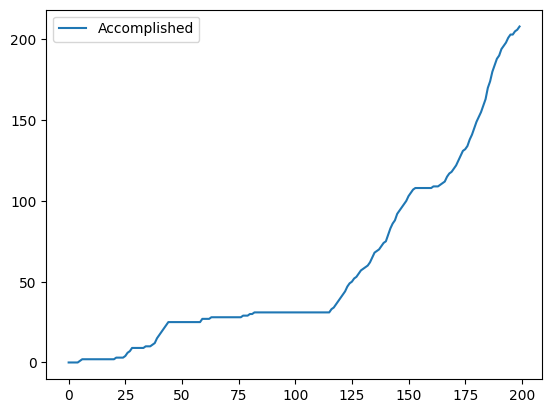

In [220]:
var = model.datacollector.get_model_vars_dataframe()
# Retrieving the data from the data collector

var.plot()



0

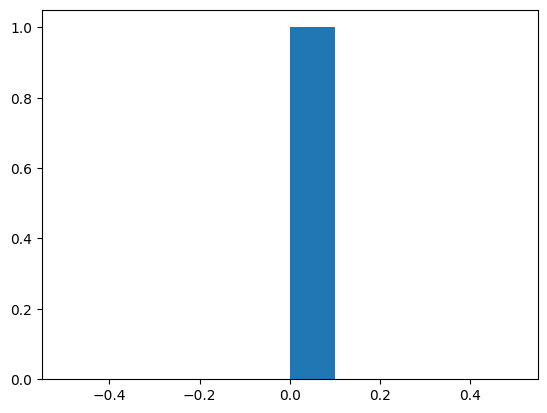

In [211]:

plt.hist(var.loc[0, "Accomplished"] )
var.loc[0, "Accomplished"]


In [179]:
# Create a visualization module using CanvasGrid
def agent_portrayal(agent):
    portrayal = {
        "Shape": "circle",
        "Filled": "true",
        "Layer": 0,
        "r": 0.5,
    }
    
    # Get the number of agents in the same grid cell
    cellmates = agent.model.grid.get_cell_list_contents([agent.pos])
    num_agents = len(cellmates)
    
    # Adjust the color or size based on the number of agents
    if num_agents > 1:
        portrayal["Color"] = "red"
        portrayal["r"] = 0.3 + (0.15 * num_agents)  # Increase size with more agents
    else:
        portrayal["Color"] = "blue"
    
    return portrayal

def cell_color(model):
    grid_colors = np.zeros((model.grid.width, model.grid.height, 3))
    
    cell = [x][y]

    for cell in model.grid.coord_iter():
        
        # Set the color based on the "accomplished" status
        if TeamAgent.working == False:
            grid_colors[x][y] = [0, 255, 0]  # Green color for accomplished cells
        else:
            grid_colors[x][y] = [255, 255, 255]  # White color for non-accomplished cells
    
    return grid_colors

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

# Create the server to visualize the model
server = ModularServer(
    TeamworkModel,
    [grid],
    "Teamwork Model",
    {"num_agents": 10, "width": 10, "height": 10},
)

server.port = 8527  # Set the port number
server.launch()  # Launch the server

Interface starting at http://127.0.0.1:8527


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}


{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step","step":33}
{"type":"get_step",

In [9]:
class TeamworkAgent(mesa.Agent):
    def __init__(self, unique_id, model, problem_solving, communication):
        super().__init__(unique_id, model)
        self.problem_solving = problem_solving # how good they are at solving problems
        self.communication = communication # how good they are at communicating
        self.working = False # whether they are working on a task

    def move(self):
        if not self.working: # if they are not working on a task
            possible_moves = self.model.grid.get_neighborhood( 
                self.pos, moore=True, include_center=False 
            )
            new_position = random.choice(possible_moves) #
            self.model.grid.move_agent(self, new_position)

    def evaluate(self):
        if self.problem_solving > self.model.task_complexity:
            self.work_individually()
        else:
            self.suggest_collaboration()

    def suggest_collaboration(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False
        )
        for neighbor in neighbors:
            if not neighbor.working:
                neighbor.jump_to_task()
                break

    def jump_to_task(self):
        self.working = True

    def collaborate(self, receiver):
        if not receiver.working:
            receiver.jump_to_task()
        elif self.problem_solving + receiver.problem_solving > self.model.task_complexity:
            self.jump_to_task()

    def work_individually(self):
        self.working = True

    def work(self):
        # Simulate work progress
        pass

    def step(self):
        self.move()
        self.evaluate()
        self.work()


In [11]:

# Create the model
class TeamworkModel(mesa.Model):
    """ A model with some number of agents."""
    
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.grid = mesa.space.MultiGrid(10, 10, torus=True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            problem_solving = random.uniform(0, 1)
            communication = random.uniform(1, 2)
            agent = TeamworkAgent(i, self, problem_solving, communication)
            self.schedule.add(agent)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.schedule.step()

(7, 3)
(1, 4)
(2, 7)
(9, 5)
(7, 8)
(0, 8)
(0, 4)
(7, 0)
(6, 1)
(6, 7)


In [51]:
# Create a CanvasGrid visualization element
def agent_portrayal(agent):
    portrayal = {
        "Shape": "circle",
        "Color": "red" if agent.working else "blue",
        "Filled": "true",
        "Layer": 0,
        "r": 0.5
    }
    return portrayal

# Create the model and run the simulation
model = TeamworkModel(num_agents=10, task_complexity=0.5)

# Create the grid visualization
grid = mesa.visualization.CanvasGrid(agent_portrayal, 10, 10, 500, 500)

# Create the server to visualize the model
server = mesa.visualization.ModularServer(
    TeamworkModel,
    [grid],
    "Teamwork Model",
    {"num_agents": 10, "task_complexity": 0.5}
)

server.port = 8521  # Set the port for the web server
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
